# Headers

In [8]:
# imports

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
import os
import itertools
from pdb import set_trace
from datetime import datetime

#plt.style.use('seaborn-pastel')
#plt.style.use('seaborn-white')
plt.style.use('fivethirtyeight')
#plt.style.use('bmh')
#plt.style.use('ggplot')
#plt.style.use('seaborn')
#plt.style.use('seaborn-paper')

plt.rcParams['axes.facecolor']='none'
plt.rcParams['savefig.facecolor']='none'
plt.rcParams['ytick.labelsize']=15
plt.rcParams['xtick.labelsize']=15
plt.rcParams['font.size']=17

%matplotlib inline

In [9]:
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [10]:
def avg_std(*vals):
    avg = []
    std = []
    #for val in zip(*vals):
    for val in itertools.zip_longest(*vals):
        avg.append(np.mean([v for v in val if v is not None]))
        std.append(np.std([v for v in val if v is not None]))
    avg = np.array(avg)
    std = np.array(std)
    return avg,std

In [281]:
def avg_std_balanced(df=None,vals=None,group=1000,groupby='walltime'):
    """
    walltime or steps
    """
    if df is None:
        df = pd.DataFrame(data={
        'walltime':vals[0],
        'reward':vals[2],
        },index=vals[1])
    if groupby == 'walltime':
        grouped = df.groupby((df.walltime//group)*group)
        idx = grouped.mean().walltime
    else:
        grouped = df.groupby((df.index//group)*group)
        idx = grouped.mean().index
        
    avg = grouped.mean().reward
    std = grouped.std().reward
    
    return avg,std,idx,df

In [12]:
def load_scalars(folder,tag="episode/episode_reward"):
    evn = EventAccumulator(folder)
    evn.Reload()
    vals = list(zip(*evn.Scalars(tag)))
    vals.append(vals[2])
    vals[2] = smooth(vals[2],.99)
    vals[0] = [val - vals[0][0] for val in vals[0]]
    return vals

In [13]:
def data_to_weights(vals,w):
    w_idx = [idx for idx,step in enumerate(vals[1]) if step >= w][0]
    print("steps to w",vals[1][w_idx])
    print("hours to w",vals[0][w_idx]/3600)
    plt.plot(vals[1],vals[2])
    plt.plot(vals[1][w_idx],vals[2][w_idx],'.r',markersize=30)

In [14]:
def merge_logs(*vals):
    val = [None,None,None,None]
    val[0] = list(vals[0][0])
    val[1] = list(vals[0][1])
    val[2] = list(vals[0][2])
    val[3] = list(vals[0][3])
    
    for v in vals[1:]:
        val[0] += [i+val[0][-1] for i in v[0]]
        val[1] += [i+val[1][-1] for i in v[1]]
        val[2] += list(v[2])
        val[3] += list(v[3])
        
    val[2] = smooth(val[3],.99)
        
    return val

In [100]:
def load_hist(file,tag):
    reader = EventFileLoader(file)
    events = [event for event in list(reader.Load()) if len(event.summary.ListFields()) > 0]

    actions = [[e.wall_time,*e.summary.value[0].histo.bucket] for e in events if tag in e.summary.value[0].tag]
    actions_id = [e.step for e in events if 'actions' in e.summary.value[0].tag]
    actions_df = pd.DataFrame(actions,index=actions_id,columns=['walltime',*events[0].summary.value[0].histo.bucket_limit])
    return actions_df

# Histograms

In [ ]:
df = pd.read_csv("../experiments/experiments.csv",index_col=0)

In [ ]:
plt.figure(figsize=(6,4))
plt.xlabel("hours",fontsize=20)
plt.ylabel("#",fontsize=20)
plot = df[df.perf == False].hours.hist(bins=30)
plt.savefig("plots/hist_hours.pdf",bbox_inches="tight", pad_inches=0)

In [ ]:
# number of experiments over 10 hours
1 - df[df.hours < 10].hours.count()/df[pd.isna(df.hours) == False].hours.count()

In [ ]:
df.hours.describe()

In [ ]:
# Total number of hours (in days)
df.hours.sum()/24

In [ ]:
plt.figure(figsize=(6,4))
plt.xlabel("# of episodes",fontsize=20)
plt.ylabel("#",fontsize=20)
df[df.perf == False].n_ep.hist(bins=25)
plt.savefig("plots/hist_n_ep.pdf",bbox_inches="tight", pad_inches=0)

# Memory plots

In [ ]:
import mprof

In [ ]:
dict_solved = mprof.plot_file("/hdd/Documents/HRL/Memory_test/mprofile_20190729151034.dat")
dict_bad    = mprof.plot_file("/hdd/Documents/HRL/Memory_test/mprofile_20190729150843.dat")

t_solved = [elem - dict_solved['timestamp'][0] for elem in dict_solved['timestamp']]
t_bad    = [elem - dict_bad['timestamp'][0]    for elem in dict_bad['timestamp']]

In [ ]:
print(dict.keys())

In [ ]:
plt.plot(t_solved,dict_solved['mem_usage'],label="v0.12.6")
plt.plot(t_bad   ,dict_bad['mem_usage'],   label="v0.12.5")
plt.ylabel("Memory used (in MiB)")
plt.xlabel("time (in seconds)")
plt.legend(loc=[1.1,0])
plt.title("Memory footprint\n")
plt.savefig("plots/mem_profiler.pdf",bbox_inches="tight", pad_inches=0)

# Histogram of actions

In [ ]:
loader = EventFileLoader("../experiments/198_Nav_new/logs/extra/events.out.tfevents.1563829770.743d94694d36")

wtimes,steps,actions = [],[],[]
for event in loader.Load():
    wtime   = event.wall_time
    step    = event.step
    if len(event.summary.value) > 0:
        summary = event.summary.value[0]
        if summary.tag == 'episode/actions':
            wtimes += [wtime]*int(summary.histo.num)
            steps  += [step] *int(summary.histo.num)

            for num,val in zip(summary.histo.bucket,summary.histo.bucket_limit):
                actions += [val] *int(num)

In [ ]:
actions = [int(round(a,0)) for a in actions]

In [ ]:
len(actions)

In [ ]:
set(actions)

In [ ]:
plt.ylabel("#",fontsize=20)
plt.xlabel("Discrete actions",fontsize=20)
plt.title("Histogram of discrete actions\n",fontsize=20)
plt.hist(actions[-2000:])
plt.savefig("plots/hist_actions.pdf",bbox_inches="tight", pad_inches=0)

In [ ]:
plt.hist(actions[:1000],density=1)

# Turn_v1 H vs N2N convergence

### n2n

In [9]:
w_times_a, step_nums_a, vals_a = pickle.load(open('./Turn_n2n_vs_h/n2n_a.pkl','rb'))
w_times_b, step_nums_b, vals_b = pickle.load(open('./Turn_n2n_vs_h/n2n_b.pkl','rb'))
w_times_c, step_nums_c, vals_c = pickle.load(open('./Turn_n2n_vs_h/n2n_c.pkl','rb'))
w_times_d, step_nums_d, vals_d = pickle.load(open('./Turn_n2n_vs_h/n2n_d.pkl','rb'))
w_times_e, step_nums_e, vals_e = pickle.load(open('./Turn_n2n_vs_h/n2n_e.pkl','rb'))

vals_a_smooth = smooth(vals_a, 0.99)
vals_b_smooth = smooth(vals_b, 0.99)
vals_c_smooth = smooth(vals_c, 0.99)
vals_d_smooth = smooth(vals_d, 0.99)
vals_e_smooth = smooth(vals_e, 0.99)

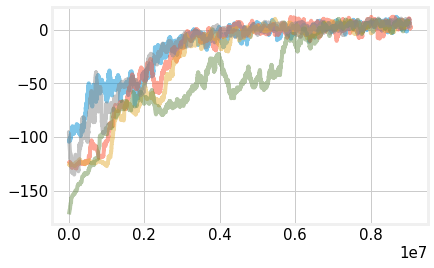

In [10]:
plt.plot(step_nums_a, vals_a_smooth,alpha=0.5)
plt.plot(step_nums_b, vals_b_smooth,alpha=0.5)
plt.plot(step_nums_c, vals_c_smooth,alpha=0.5)
plt.plot(step_nums_d, vals_d_smooth,alpha=0.5)
plt.plot(step_nums_e, vals_e_smooth,alpha=0.5)

In [11]:
print("min max step",min([max(step) for step in [step_nums_a,step_nums_b,step_nums_c,step_nums_d,step_nums_e]]))
print("max step",max([max(step) for step in [step_nums_a,step_nums_b,step_nums_c,step_nums_d,step_nums_e]]))

min max step 9000609
max step 9058865


#### plots times to max

In [36]:
def plt_max(steps,vals,walltime = None):
    if walltime is not None:
        print("time to val", (walltime[[idx for idx,val in enumerate(vals) if val >0][0]]-walltime[0])/3600)
    plt.plot(steps, vals)
    plt.plot(steps[[idx for idx,val in enumerate(vals) if val >0][0]],vals[[idx for idx,val in enumerate(vals) if val >0][0]],'.',alpha=1)


time to val 9.361574464440345


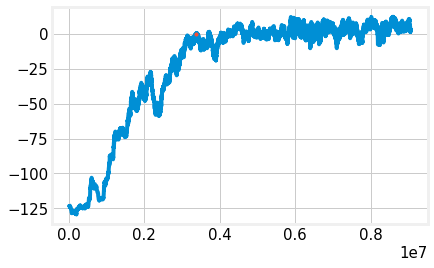

In [37]:
plt_max(step_nums_b,vals_b_smooth,w_times_b)

time to val 139.1734584971269


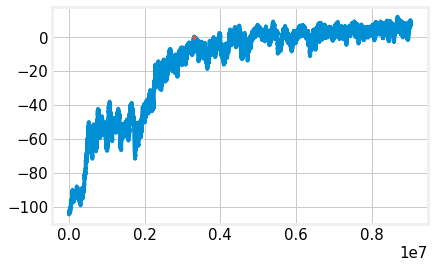

In [38]:
plt_max(step_nums_a,vals_a_smooth,w_times_a)

time to val 14.971363103522195


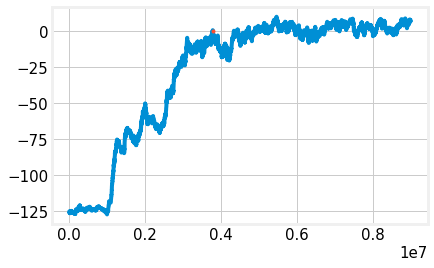

In [39]:
plt_max(step_nums_c,vals_c_smooth,w_times_c)

time to val 24.489542881382835


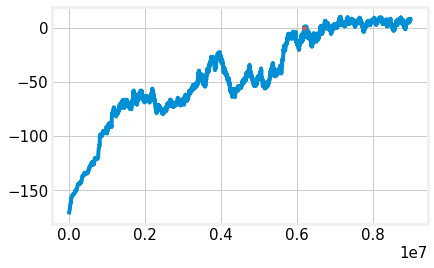

In [40]:
plt_max(step_nums_d,vals_d_smooth,w_times_d)

time to val 77.65863418552611


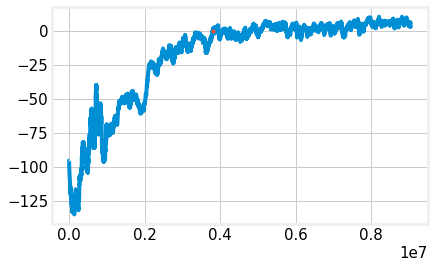

In [41]:
plt_max(step_nums_e,vals_e_smooth,w_times_e)

#### unrealiable walltime

In [53]:
# un realible walltime
print("a) hours to reach 0",(w_times_a[[idx for idx,val in enumerate(vals_a_smooth) if val >0][0]]-w_times_a[0])/3600)
print("b) hours to reach 0",(w_times_b[[idx for idx,val in enumerate(vals_b_smooth) if val >0][0]]-w_times_b[0])/3600)
print("c) hours to reach 0",(w_times_c[[idx for idx,val in enumerate(vals_c_smooth) if val >0][0]]-w_times_c[0])/3600)
print("d) hours to reach 0",(w_times_d[[idx for idx,val in enumerate(vals_d_smooth) if val >0][0]]-w_times_d[0])/3600)
print("e) hours to reach 0",(w_times_e[[idx for idx,val in enumerate(vals_e_smooth) if val >0][0]]-w_times_e[0])/3600)


a) hours to reach 0 139.1734584971269
b) hours to reach 0 9.361574464440345
c) hours to reach 0 14.971363103522195
d) hours to reach 0 24.489542881382835
e) hours to reach 0 77.65863418552611


#### steps to 0

In [58]:
print("a) steps to reach 0",step_nums_a[[idx for idx,val in enumerate(vals_a_smooth) if val >0][0]])
print("b) steps to reach 0",step_nums_b[[idx for idx,val in enumerate(vals_b_smooth) if val >0][0]])
print("c) steps to reach 0",step_nums_c[[idx for idx,val in enumerate(vals_c_smooth) if val >0][0]])
print("d) steps to reach 0",step_nums_d[[idx for idx,val in enumerate(vals_d_smooth) if val >0][0]])
print("e) steps to reach 0",step_nums_e[[idx for idx,val in enumerate(vals_e_smooth) if val >0][0]])
print("avg steps to reach 0", (
    step_nums_a[[idx for idx,val in enumerate(vals_a_smooth) if val >0][0]]+\
    step_nums_b[[idx for idx,val in enumerate(vals_a_smooth) if val >0][0]]+\
    step_nums_c[[idx for idx,val in enumerate(vals_b_smooth) if val >0][0]]+\
    step_nums_d[[idx for idx,val in enumerate(vals_c_smooth) if val >0][0]]+\
    step_nums_e[[idx for idx,val in enumerate(vals_d_smooth) if val >0][0]])/5)


a) steps to reach 0 3308320
b) steps to reach 0 3364377
c) steps to reach 0 3785443
d) steps to reach 0 6204865
e) steps to reach 0 3799573
avg steps to reach 0 4073666.6


#### plots

In [13]:
w_times_a = [wt - w_times_a[0] for wt in w_times_a]
w_times_b = [wt - w_times_b[0] for wt in w_times_b]
w_times_c = [wt - w_times_c[0] for wt in w_times_c]
w_times_d = [wt - w_times_d[0] for wt in w_times_d]
w_times_e = [wt - w_times_e[0] for wt in w_times_e]

df = pd.DataFrame(data={
    'walltime':w_times_a+w_times_b+w_times_c+w_times_d+w_times_e,
    'discounted_rewards':vals_a_smooth+vals_b_smooth+vals_c_smooth+vals_d_smooth+vals_e_smooth
    },index=step_nums_a+step_nums_b+step_nums_c+step_nums_d+step_nums_e)

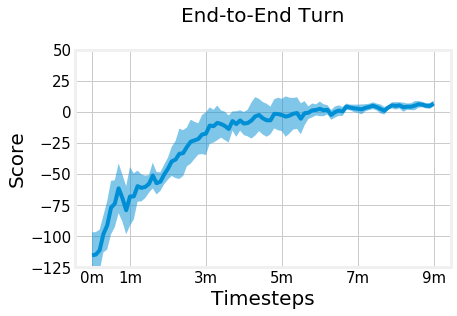

In [22]:
n2n_avg = df.groupby((df.index//100000)*100000).mean().discounted_rewards
n2n_wt  = df.groupby((df.index//100000)*100000).mean().walltime
n2n_std = df.groupby((df.index//100000)*100000).std().discounted_rewards
n2n_stp = n2n_avg.index

plt.plot(n2n_stp,n2n_avg)
plt.fill_between(n2n_stp,n2n_avg-n2n_std,n2n_avg+n2n_std,alpha=.5)
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("End-to-End Turn\n",fontsize=20)
plt.xticks([0,1e6,3e6,5e6,7e6,9e6],["0m","1m","3m","5m","7m","9m"])
plt.ylim(-125,50)
plt.savefig("plots/n2n-turn.pdf",bbox_inches="tight", pad_inches=0)

### H

In [15]:
w_times_h_a, step_nums_h_a, vals_h_a = pickle.load(open('./Turn_n2n_vs_h/h_a.pkl','rb'))
w_times_h_b, step_nums_h_b, vals_h_b = pickle.load(open('./Turn_n2n_vs_h/h_b.pkl','rb'))
vals_h_a_smooth = smooth(vals_h_a, 0.99)
vals_h_b_smooth = smooth(vals_h_b, 0.99)

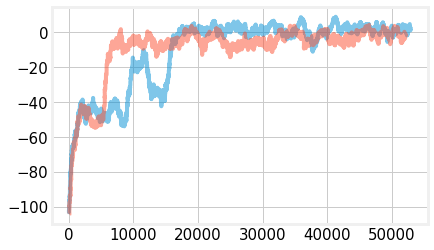

In [16]:
plt.plot(step_nums_h_a, vals_h_a_smooth,alpha=0.5)
plt.plot(step_nums_h_b, vals_h_b_smooth,alpha=0.5)

In [17]:
w_times_h_a = [wt - w_times_h_a[0] for wt in w_times_h_a]
w_times_h_b = [wt - w_times_h_b[0] for wt in w_times_h_b]

df_h = pd.DataFrame(data={
    'walltime':w_times_h_a+w_times_h_b,
    'discounted_rewards':vals_h_a+vals_h_b,
    },index=step_nums_h_a+step_nums_h_b)

#### plots

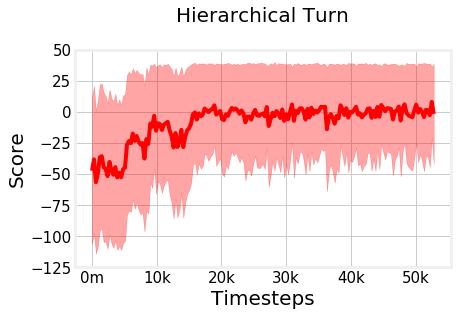

In [21]:
h_avg = df_h.groupby((df_h.index//300)*300).mean().discounted_rewards
h_wt  = df_h.groupby((df_h.index//300)*300).mean().walltime
h_std = df_h.groupby((df_h.index//300)*300).std().discounted_rewards
h_stp = h_avg.index

plt.plot(h_stp,h_avg,color='red')
plt.fill_between(h_stp,h_avg-h_std,h_avg+h_std,alpha=.35,color='red')
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("Hierarchical Turn\n",fontsize=20)
plt.xticks([0,1e4,2e4,3e4,4e4,5e4],["0m","10k","20k","30k","40k","50k"])
plt.ylim(-125,50)
plt.savefig("plots/h-turn.pdf",bbox_inches="tight", pad_inches=0)

In [20]:
tleft = EventAccumulator('../experiments/84_Turn_left_v2/logs/PPO2_1')
tleft.Reload()
tright = EventAccumulator('../experiments/85_Turn_right_v2/logs/PPO2_1')
tright.Reload()

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


In [99]:
tleft_vals = list(zip(*tleft.Scalars("episode/episode_reward")))
tright_vals = list(zip(*tright.Scalars("episode/episode_reward")))
tleft_vals[2] = smooth(tleft_vals[2],.99)
tright_vals[2] = smooth(tright_vals[2],.99)
tleft_vals[0] = [i - tleft_vals[0][0] for i in tleft_vals[0]]
tright_vals[0] = [i - tright_vals[0][0] for i in tright_vals[0]]

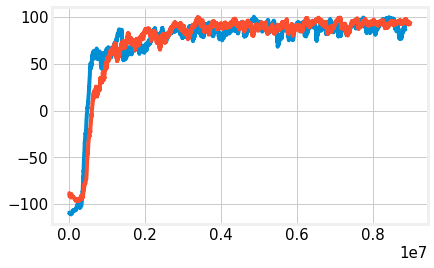

In [100]:
plt.plot(tleft_vals[1],tleft_vals[2])
plt.plot(tright_vals[1],tright_vals[2])

#### Data

In [114]:
print("a) steps to reach 0:",step_nums_h_a[[idx for idx,val in enumerate(vals_h_a_smooth) if val > 0][0]])
print("b) steps to reach 0:",step_nums_h_b[[idx for idx,val in enumerate(vals_h_b_smooth) if val > 0][0]])
print("avg) steps to reach 0:", (
    step_nums_h_a[[idx for idx,val in enumerate(vals_h_a_smooth) if val > 0][0]]+\
    step_nums_h_b[[idx for idx,val in enumerate(vals_h_b_smooth) if val > 0][0]])/2)

a) steps to reach 0: 17027
b) steps to reach 0: 7969
avg) steps to reach 0: 12498.0


In [304]:
print("Step to reach last mean left",tleft_vals[1][[idx for idx,val in enumerate(tleft_vals[2]) if val > np.mean(tleft_vals[2][1000:])][0]])
print("Step to reach last mean right",tright_vals[1][[idx for idx,val in enumerate(tright_vals[2]) if val > np.mean(tright_vals[2][1000:])][0]])
print("Time to reach last mean left",tleft_vals[0][[idx for idx,val in enumerate(tleft_vals[2]) if val > np.mean(tleft_vals[2][1000:])][0]]/3600)
print("Time to reach last mean right",tright_vals[0][[idx for idx,val in enumerate(tright_vals[2]) if val > np.mean(tright_vals[2][1000:])][0]]/3600)
print("Time to reach last mean right+left",(tleft_vals[0][[idx for idx,val in enumerate(tleft_vals[2]) if val > np.mean(tleft_vals[2][1000:])][0]]/3600 + tright_vals[0][[idx for idx,val in enumerate(tright_vals[2]) if val > np.mean(tright_vals[2][1000:])][0]]/3600))


Step to reach last mean left 1317131
Step to reach last mean right 2697004
Time to reach last mean left 8.069585235383775
Time to reach last mean right 16.74599057568444
Time to reach last mean right+left 24.815575811068214


In [73]:
print("steps to reach max in Turn_left", tleft_vals[1][tleft_vals[2].index(max(tleft_vals[2]))])
print("steps to reach max in Turn_right",tright_vals[1][tright_vals[2].index(max(tright_vals[2]))])
print("total steps to reach max in Turn_left + Right", tleft_vals[1][tleft_vals[2].index(max(tleft_vals[2]))]+tright_vals[1][tright_vals[2].index(max(tright_vals[2]))])
print("steps to reach max in Turn", h_avg.idxmax())
print("total steps to reach max", tleft_vals[1][tleft_vals[2].index(max(tleft_vals[2]))]+tright_vals[1][tright_vals[2].index(max(tright_vals[2]))]+h_avg.idxmax())

steps to reach max in Turn_left 5841777
steps to reach max in Turn_right 1929179
total steps to reach max in Turn_left + Right 7770956
steps to reach max in Turn 52500
total steps to reach max 7823456


# Turn_v1 H vs N2N wall-time

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


([<matplotlib.axis.XTick at 0x14d678550>,
 <a list of 6 Text xticklabel objects>)

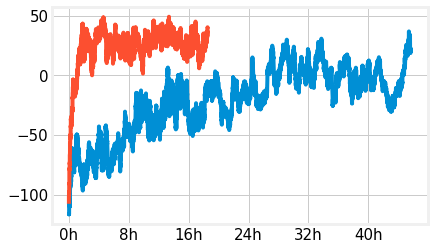

In [122]:
n2n_event_1 = EventAccumulator("../experiments/240_Turn_v1_n2n_control/logs/PPO2_1/")
n2n_event_2 = EventAccumulator("../experiments/244_Turn_v1_n2n_control/logs/PPO2_1/")
h_event   = EventAccumulator("../experiments/241_Turn_v1_H_control/logs/PPO2_1/")
n2n_event_1.Reload()
n2n_event_2.Reload()
h_event.Reload()

n2n_1 = list(zip(*n2n_event_1.Scalars("episode/episode_reward")))
n2n_2 = list(zip(*n2n_event_2.Scalars("episode/episode_reward")))
h   = list(zip(*h_event.Scalars("episode/episode_reward")))

n2n_1[0] = [v - n2n_1[0][0] for v in n2n_1[0]]
n2n_2[0] = [v - n2n_2[0][0] for v in n2n_2[0]]
h[0] = [v - h[0][0] for v in h[0]]

n2n = [None, None, None]
n2n[0] = list(n2n_1[0]) + [v + n2n_1[0][-1] for v in n2n_2[0]]
n2n[1] = list(n2n_1[1]) + [v + n2n_1[1][-1] for v in n2n_2[1]]
n2n[2] = list(n2n_1[2]) + list(n2n_2[2])

n2n[2] = smooth(n2n[2],.99)
h[2]   = smooth(h[2],.99)

plt.plot(n2n[0],n2n[2])
plt.plot(h[0],h[2])
plt.xticks([8*i*3600 for i in range(6)],[str(i*8)+"h" for i in range(6)])

###  data

In [138]:
convergance = np.mean(h[2][100:])
print("time to reach mean in h is",h[0][[idx for idx,val in enumerate(h[2]) if val > convergance][0]]/3600)
#convergance = np.mean(n2n[2][10000:])*0
print("time to reach mean in n2n is",n2n[0][[idx for idx,val in enumerate(n2n[2]) if val > convergance][0]]/3600)

time to reach mean in h is 1.5970309578710131
time to reach mean in n2n is 28.613023971915243


# Turn v2 walltime / steps n2n v H (exp from server)

In [74]:
t2_h_evn = EventAccumulator("../experiments/235_Turn_H_v2_for_wtime/logs/PPO2_1/")
t2_n2n_evn   = EventAccumulator("../experiments/234_Turn_n2n_v2_for_wtime/logs/PPO2_1/")
t2_h_evn.Reload()
t2_n2n_evn.Reload()

t2_n = list(zip(*t2_n2n_evn.Scalars("episode/episode_reward")))
t2_h = list(zip(*t2_h_evn.Scalars("episode/episode_reward")))

t2_n[2] = smooth(t2_n[2],.99)
t2_h[2] = smooth(t2_h[2],.99)

t2_n[0] = [v - t2_n[0][0] for v in t2_n[0]]
t2_h[0] = [v - t2_h[0][0] for v in t2_h[0]]

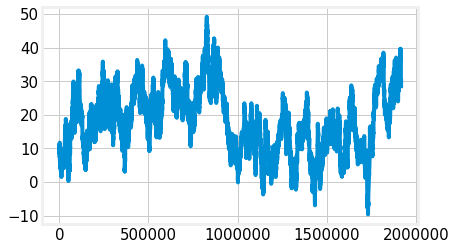

In [26]:
plt.plot(t2_h[1],t2_h[2])

In [75]:
df_h = pd.DataFrame(data={
    'walltime':t2_h[0],
    'r':t2_h[2],
    },index=t2_h[1])
df_n = pd.DataFrame(data={
    'walltime':t2_n[0],
    'r':t2_n[2],
    },index=t2_n[1])

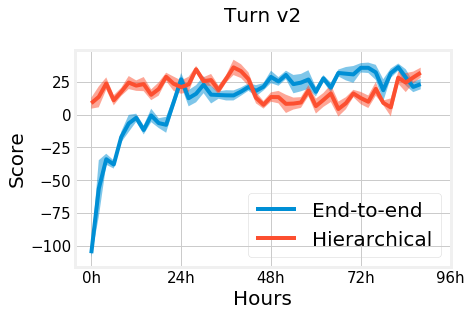

In [28]:
k = 2*60*60
h_avg = df_h.groupby((df_h.walltime//k)*k).mean().discounted_rewards
h_wt  = df_h.groupby((df_h.walltime//k)*k).mean().walltime
h_std = df_h.groupby((df_h.walltime//k)*k).std().discounted_rewards
h_stp = h_avg.index

n_avg = df_n.groupby((df_n.walltime//k)*k).mean().discounted_rewards
n_wt  = df_n.groupby((df_n.walltime//k)*k).mean().walltime
n_std = df_n.groupby((df_n.walltime//k)*k).std().discounted_rewards
n_stp = n_avg.index

plt.plot(n_stp,n_avg,label="End-to-end")
plt.fill_between(n_stp,n_avg-n_std,n_avg+n_std,alpha=.5)
plt.plot(h_stp,h_avg,label="Hierarchical")
plt.fill_between(h_stp,h_avg-h_std,h_avg+h_std,alpha=.5)
plt.xlabel("Hours",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("Turn v2\n",fontsize=20)
plt.xticks([24*i*3600 for i in range(5)],[str(i*24)+"h" for i in range(5)])
plt.legend(fontsize=20)
#plt.savefig("plots/Turn-v2-n2n-h.pdf",bbox_inches="tight", pad_inches=0)

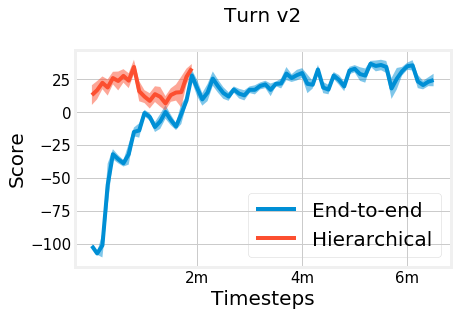

In [29]:
k = 100000
h_avg = df_h.groupby((df_h.index//k)*k).mean().discounted_rewards
h_wt  = df_h.groupby((df_h.index//k)*k).mean().walltime
h_std = df_h.groupby((df_h.index//k)*k).std().discounted_rewards
h_stp = h_avg.index

n_avg = df_n.groupby((df_n.index//k)*k).mean().discounted_rewards
n_wt  = df_n.groupby((df_n.index//k)*k).mean().walltime
n_std = df_n.groupby((df_n.index//k)*k).std().discounted_rewards
n_stp = n_avg.index

plt.plot(n_stp,n_avg,label="End-to-end")
plt.fill_between(n_stp,n_avg-n_std,n_avg+n_std,alpha=.5)
plt.plot(h_stp,h_avg,label="Hierarchical")
plt.fill_between(h_stp,h_avg-h_std,h_avg+h_std,alpha=.5)
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("Turn v2\n",fontsize=20)
plt.xticks([2e6,4e6,6e6],["2m","4m","6m"])
plt.legend(fontsize=20)
plt.savefig("plots/Turn-v2-n2n-h.pdf",bbox_inches="tight", pad_inches=0)

#### data

In [120]:
print("steps to reach 25 in N2N",df_n[df_n.r > 25].index[0])
print("steps to reach 25 in Hie",df_h[df_h.r > 25].index[0])

steps to reach 25 in N2N 1914513
steps to reach 25 in Hie 76880


In [ ]:
print("hours to reach 25 in N2N",df_n[df_n.r > 25].iloc[0].walltime/3600)
print("hours to reach 25 in Hie",df_h[df_h.r > 25].iloc[0].walltime/3600)

# Nav H vs N2N

### n2n - steps

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


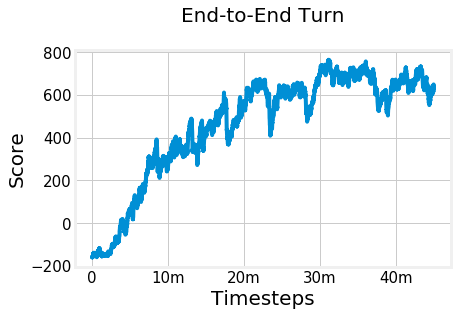

In [139]:
n2n_nav = EventAccumulator('../experiments/198_Nav_new/logs/PPO2_1')
n2n_nav.Reload()

wtimes_n2n_Nav, steps_n2n_Nav, val_n2n_Nav = zip(*n2n_nav.Scalars("episode/episode_reward"))
val_n2n_Nav_smooth = smooth(val_n2n_Nav,0.99)

plt.plot(steps_n2n_Nav,val_n2n_Nav_smooth)
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("End-to-End Turn\n",fontsize=20)
plt.xticks([0,1e7,2e7,3e7,4e7],['0','10m','20m','30m','40m'])
plt.savefig("plots/n2n-turn.pdf",bbox_inches="tight", pad_inches=0)

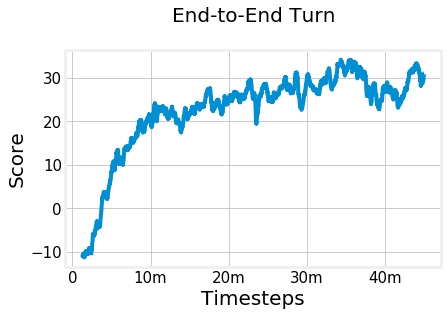

In [186]:
wtimes_n2n_Nav, steps_n2n_Nav, val_n2n_Nav = zip(*n2n_nav.Scalars("input_info/discounted_rewards"))
val_n2n_Nav_smooth = smooth(val_n2n_Nav,0.99)
wtimes_n2n_Nav = [val - wtimes_n2n_Nav[0] for val in wtimes_n2n_Nav]

plt.plot(steps_n2n_Nav[300:],val_n2n_Nav_smooth[300:])
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("End-to-End Turn\n",fontsize=20)
plt.xticks([0,1e7,2e7,3e7,4e7],['0','10m','20m','30m','40m'])
plt.savefig("plots/n2n-turn.pdf",bbox_inches="tight", pad_inches=0)

In [187]:
print("hours to reach max",(wtimes_n2n_Nav[val_n2n_Nav.index(max(val_n2n_Nav))]-wtimes_n2n_Nav[0])/3600)
print("steps to reach max",steps_n2n_Nav[val_n2n_Nav.index(max(val_n2n_Nav))])

hours to reach max 114.61110918727186
steps to reach max 36050727


In [188]:
convergence = np.mean(val_n2n_Nav_smooth[7000:])
print("hours to get to mean in H",wtimes_n2n_Nav[[idx for idx,val in enumerate(val_n2n_Nav_smooth) if val > convergence][0]]/3600)
print("steps to get to mean in H",steps_n2n_Nav[[idx for idx,val in enumerate(val_n2n_Nav_smooth) if val > convergence][0]])

hours to get to mean in H 75.98946622053782
steps to get to mean in H 22513848


### H - steps

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


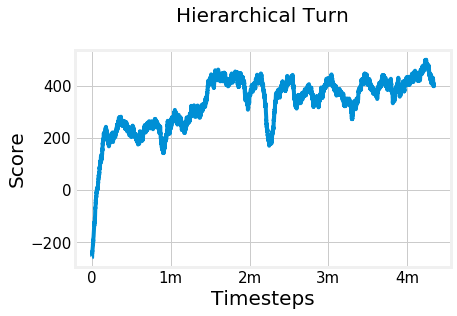

In [158]:
h_nav = EventAccumulator('../experiments/233_Nav_from_zero/logs/PPO2_1/')
h_nav.Reload()

wtimes_h_Nav, steps_h_Nav, val_h_Nav = zip(*h_nav.Scalars("episode/episode_reward"))
val_h_Nav_smooth = smooth(val_h_Nav,0.99)
wtimes_h_Nav = [val-wtimes_h_Nav[0] for val in wtimes_h_Nav]

plt.plot(steps_h_Nav,val_h_Nav_smooth)
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("Hierarchical Turn\n",fontsize=20)
plt.xticks([0,1e6,2e6,3e6,4e6],['0','1m','2m','3m','4m'])
plt.savefig("plots/h-turn.pdf",bbox_inches="tight", pad_inches=0)

In [159]:
print("hours to reach max",(wtimes_h_Nav[val_h_Nav.index(max(val_h_Nav))]-wtimes_h_Nav[0])/3600)
print("steps to reach max",steps_h_Nav[val_h_Nav.index(max(val_h_Nav))])

hours to reach max 22.705698146621387
steps to reach max 3104484


In [166]:
convergence = np.mean(val_h_Nav_smooth[5000:])
print("hours to get to mean in H",wtimes_h_Nav[[idx for idx,val in enumerate(val_h_Nav_smooth) if val > convergence][0]]/3600)
print("steps to get to mean in H",steps_h_Nav[[idx for idx,val in enumerate(val_h_Nav_smooth) if val > convergence][0]])


hours to get to mean in H 10.759205573201179
steps to get to mean in H 1465424


### Hierarchy of Nav data

#### NWO    exp148 2053056.pkl

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


steps to w 2053062
hours to w 22.2036896498998


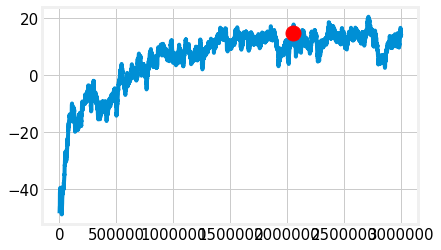

In [220]:
nwo = load_scalars("../experiments/148_NWO_2.0/logs/PPO2_1/")
data_to_weights(nwo,2053056)

#### NWOO   exp199 5176512.pkl

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


steps to w 5176754
hours to w 54.72249409059683


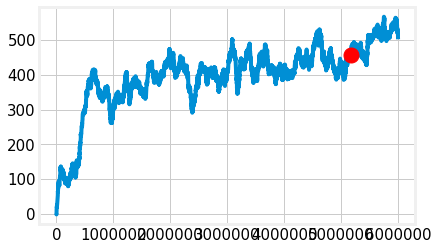

In [221]:
nwoo = load_scalars("../experiments/199_NWOO_B/logs/PPO2_1/")
data_to_weights(nwoo,5176512)

#### R      exp96  final.pkl

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


steps to w 1930846
hours to w 8.61492194963826


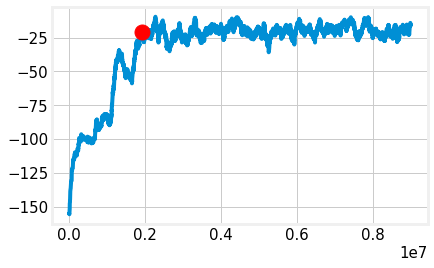

In [237]:
r = load_scalars("../experiments/96_Recovery_direct/logs/PPO2_1/")
data_to_weights(r,r[1][[idx for idx,val in enumerate(r[2]) if val >= np.mean(r[2][-1000:])][0]])

#### X      exp160 784992.pkl

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


steps to w 785023
hours to w 14.772476487490867


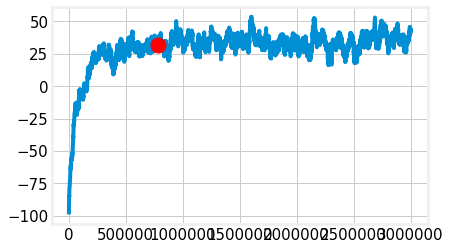

In [223]:
x = load_scalars("../experiments/160_X_max_steps_v1.1_NEW/logs/PPO2_1/")
data_to_weights(x,784992)

#### KL     71 or 72

In [239]:
kl_71 = load_scalars("../experiments/71_Keep_lane/logs/PPO2_1/")
kl_72 = load_scalars("../experiments/72_Keep_lane_cont/logs/PPO2_1/")

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


In [250]:
kl = [None,None,None]
kl[0] = list(kl_71[0]) + [val+kl_71[0][-1] for val in kl_72[0]]
kl[1] = list(kl_71[1]) + [val+kl_71[1][-1] for val in kl_72[1]]
kl[2] = list(kl_71[2]) + list(kl_72[2])

steps to w 6914848
hours to w 19.325977686511145


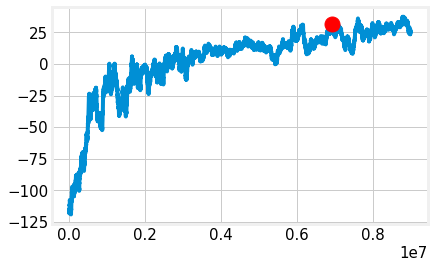

In [253]:
data_to_weights(kl,kl[1][[idx for idx,val in enumerate(kl[2]) if val >= np.mean(kl[2][-500:])][0]])

#### TC     24,25,26,27

In [264]:
tc_24 = load_scalars("../experiments/24_Take_center/logs/PPO2_1/")
tc_25 = load_scalars("../experiments/25_Take_center_cont/logs/PPO2_1/")
tc_26 = load_scalars("../experiments/26_Take_center_cont2/logs/PPO2_1/")
tc_27 = load_scalars("../experiments/27_Take_center_cont3/logs/PPO2_1/")
tc = merge_logs(tc_24,tc_25,tc_26,tc_27)

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


steps to w 267717
hours to w 3.460279119743241


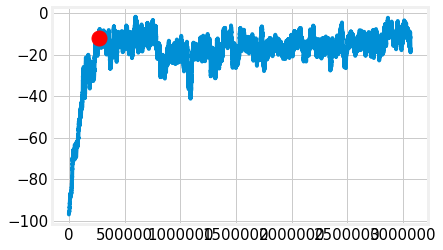

In [299]:
data_to_weights(tc,tc[1][[idx for idx,val in enumerate(tc[2]) if val >= np.mean(tc[2][-100])][0]])

#### Turn   exp147 1347216.pkl

In [300]:
turn1 = load_scalars("../experiments/136_Turn_maxsteps4_new/logs/PPO2_1/")
turn2 = load_scalars("../experiments/147_Turn_maxsteps4_new_cont/logs/PPO2_1/")
turn = merge_logs(turn1,turn2)

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


steps to w 1347226
hours to w 31.63091956006156


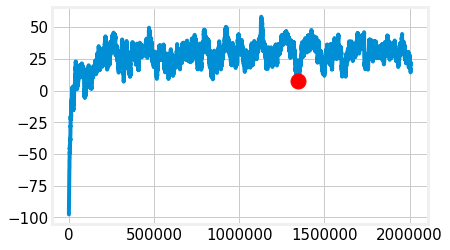

In [301]:
data_to_weights(turn,1347216)

#### TLeft  exp111 12601008.pkl (see Turn v1)

In [302]:
tleft0 = load_scalars("../experiments/84_Turn_left_v2/logs/PPO2_1/")
tleft1 = load_scalars("../experiments/111_Turn_left_v2.1/logs/PPO2_1/")
tleft = merge_logs(tleft0,tleft1)

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


steps to w 12604991
hours to w 94.00004697422186


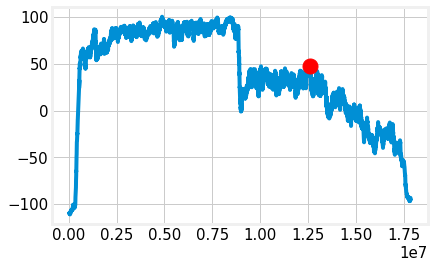

In [303]:
data_to_weights(tleft,12601008)

#### TRight exp112 12601008.pkl (see Turn v1)

In [255]:
tright = load_scalars("../experiments/112_Turn_right_v2.1/logs/PPO2_1/")
data_to_weights(tright,12601008)

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


IndexError: list index out of range

#### CLane  exp135 3500928.pkl

In [305]:
clane0 = load_scalars("../experiments/134_CL_B/logs/PPO2_1/")
clane1 = load_scalars("../experiments/135_CL_B_cont/logs/PPO2_1/")
clane = merge_logs(clane0,clane1)

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


steps to w 3501137
hours to w 39.79435845017433


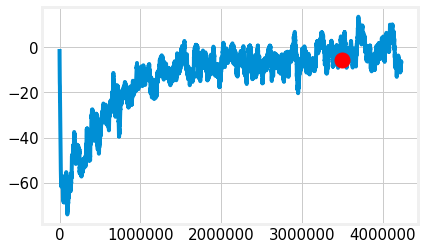

In [306]:
data_to_weights(clane,3500928)

#### CL     exp127 final.pkl

In [313]:
cleft = load_scalars("../experiments/127_CLeft_1.3/logs/PPO2_1/")

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


steps to w 1768281
hours to w 12.065061043898265


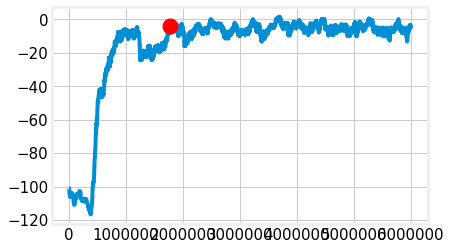

In [314]:
data_to_weights(cleft,cleft[1][[idx for idx,val in enumerate(cleft[2]) if val >= np.mean(cleft[2][-5000])][0]])

#### CR     exp115 2402304.pkl

steps to w 2402309
hours to w 19.69818727519777


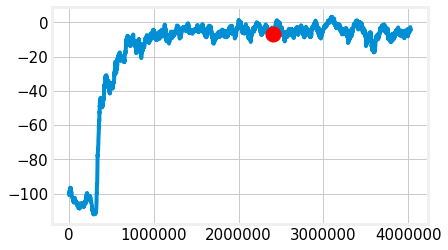

In [309]:
cright = load_scalars("../experiments/115_CRight_1.3/logs/PPO2_1/")
data_to_weights(cright,2402304)

### Using pandas individual plots

In [23]:
h_nav_evn = EventAccumulator('../experiments/233_Nav_from_zero/logs/PPO2_1/')
h_nav_evn.Reload()
h_nav = list(zip(*h_nav_evn.Scalars("episode/episode_reward")))
h_nav[2] = smooth(h_nav[2],.99)

n2n_nav_evn = EventAccumulator('../experiments/198_Nav_new/logs/PPO2_1')
n2n_nav_evn.Reload()
n_nav = list(zip(*n2n_nav_evn.Scalars("episode/episode_reward")))
n_nav[2] = smooth(n_nav[2],0.99)

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


In [24]:
df_n_nav = pd.DataFrame(data={
    'walltime':n_nav[0],
    'r':n_nav[2],
    },index=n_nav[1])
df_h_nav = pd.DataFrame(data={
    'walltime':h_nav[0],
    'r':h_nav[2],
    },index=h_nav[1])

In [25]:
k = 50000
r_h = df_h_nav.groupby((df_h_nav.index//k)*k).mean().r
std_h = df_h_nav.groupby((df_h_nav.index//k)*k).std().r
stp_h = r_h.index
wt_h = df_h_nav.groupby((df_h_nav.index//k)*k).std().walltime

k = 500000
r_n = df_n_nav.groupby((df_n_nav.index//k)*k).mean().r
std_n = df_n_nav.groupby((df_n_nav.index//k)*k).std().r
stp_n = r_n.index
wt_n = df_n_nav.groupby((df_n_nav.index//k)*k).std().walltime

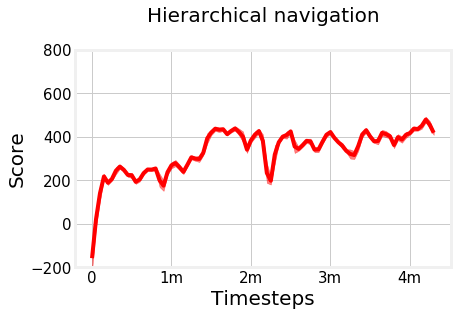

In [26]:
plt.plot(stp_h,r_h,color='red')
plt.fill_between(stp_h,r_h-std_h,r_h+std_h,alpha=.5,color='red')
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("Hierarchical navigation\n",fontsize=20)
plt.xticks([0,1e6,2e6,3e6,4e6],["0","1m","2m","3m","4m"])
plt.ylim(-200,800)
plt.savefig("plots/H_Nav_steps.pdf",bbox_inches="tight", pad_inches=0)

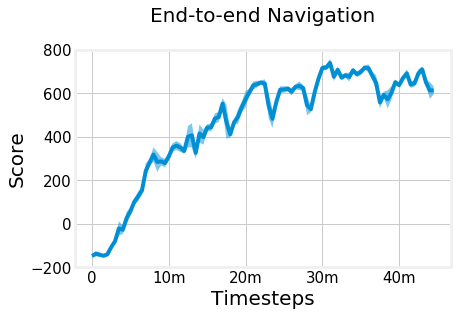

In [27]:
plt.plot(stp_n,r_n)
plt.fill_between(stp_n,r_n-std_n,r_n+std_n,alpha=.5)
plt.xlabel("Timesteps",fontsize=20)
plt.ylabel("Score",fontsize=20)
plt.title("End-to-end Navigation\n",fontsize=20)
plt.xticks([1e7,2e7,3e7,4e7,0],["10m","20m","30m","40m","0"])
plt.ylim(-200,800)
plt.savefig("plots/n2n_Nav_steps.pdf",bbox_inches="tight", pad_inches=0)

### wall-time both plots

In [181]:
h_nav = EventAccumulator('../experiments/233_Nav_from_zero/logs/PPO2_1/')
n2n_nav = EventAccumulator('../experiments/198_Nav_new/logs/PPO2_1')
n2n_nav.Reload()
h_nav.Reload()

Nav_n = list(zip(*n2n_nav.Scalars("episode/episode_reward")))
Nav_h = list(zip(*h_nav.Scalars("episode/episode_reward")))

Nav_n[2] = smooth(Nav_n[2],0.99)
Nav_h[2] = smooth(Nav_h[2],0.99)

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


In [182]:
Nav_n[0] = [v - Nav_n[0][0] for v in Nav_n[0]]
Nav_h[0] = [v - Nav_h[0][0] for v in Nav_h[0]]

([<matplotlib.axis.XTick at 0x1785d8ba8>,
 <a list of 7 Text xticklabel objects>)

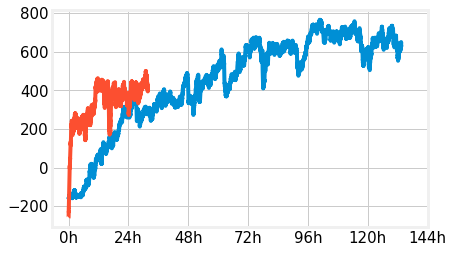

In [187]:
plt.plot(Nav_n[0],Nav_n[2])
plt.plot(Nav_h[0],Nav_h[2])
plt.xticks([i*24*3600 for i in range(7)],[str(i*24)+"h" for i in range(7)])

# Turn old histogram of actions

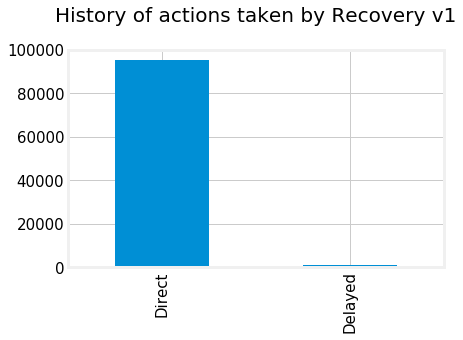

In [149]:
actions_df = load_hist("../experiments/98_Recovery_dummy/logs/extra/events.out.tfevents.1561361727.29530bff75af","actions")
actions_df.loc[:,actions_df.columns[1:]].groupby(by=int, axis='columns').sum().sum().plot("bar")
plt.xticks([0,1],["Direct","Delayed"])
plt.title("History of actions taken by Recovery v1\n",fontsize=20)
plt.savefig("plots/actions_recovery_old.pdf",bbox_inches="tight", pad_inches=0)

# Performance on obstacles and intersections

In [17]:
n2n_obs_r = load_scalars("../experiments/251_Nav_n2n_perf_obstacles/logs/extra/","episode/episode_reward")
n2n_obs_f = load_scalars("../experiments/251_Nav_n2n_perf_obstacles/logs/extra/","episode/full_reward")

n2n_int_r = load_scalars("../experiments/254_Nav_n2n_perf_intersections/logs/extra/","episode/episode_reward")
n2n_int_f = load_scalars("../experiments/254_Nav_n2n_perf_intersections/logs/extra/","episode/full_reward")

h_obs_r = load_scalars("../experiments/252_Nav_H_perf_obstacles/logs/extra","episode/episode_reward")
h_obs_f = load_scalars("../experiments/252_Nav_H_perf_obstacles/logs/extra","episode/full_reward")

h_int_r = load_scalars("../experiments/253_Nav_perf_intersections/logs/extra","episode/episode_reward")
h_int_f = load_scalars("../experiments/253_Nav_perf_intersections/logs/extra","episode/full_reward")

In [18]:
n2n_obs_ratio = [1 - r/f for r,f in zip(n2n_obs_r[2],n2n_obs_f[2])]
n2n_int_ratio = [r/f for r,f in zip(n2n_int_r[2],n2n_int_f[2])]
h_obs_ratio =   [1 - r/f for r,f in zip(h_obs_r[2],h_obs_f[2])]
h_int_ratio =   [r/f for r,f in zip(h_int_r[2],h_int_f[2])]

assert len(n2n_obs_ratio) == 100
assert len(n2n_int_ratio) == 100
assert len(h_obs_ratio) == 100
assert len(h_int_ratio) == 100

In [95]:
mean  = np.mean([n2n_obs_ratio,n2n_int_ratio,h_obs_ratio,h_int_ratio],axis=1)
std   = np.std( [n2n_obs_ratio,n2n_int_ratio,h_obs_ratio,h_int_ratio],axis=1)
print("mean",mean)
print("std", std)

mean [0.86870866 0.7417554  0.72367727 0.70596603]
std [0.0064     0.01644775 0.00342977 0.05256678]


In [96]:
print("difference in int rate",mean[1]-mean[3])
print("difference in obs rate",mean[0]-mean[2])

difference in int rate 0.035789367532469085
difference in obs rate 0.14503139263083253


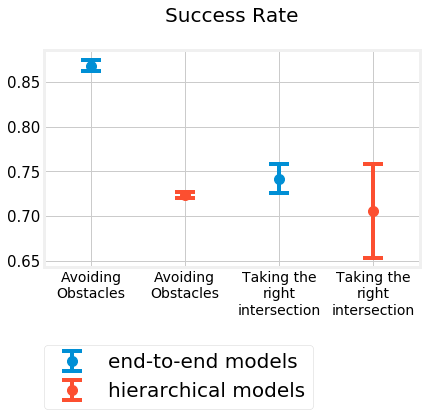

In [94]:
plt.errorbar([0,2],mean[0:2],std[0:2],linestyle='None',marker='o',label="end-to-end models",capsize=10,capthick=4,markersize=10)
plt.errorbar([1,3],mean[2:], std[2:], linestyle='None',marker='o',label="hierarchical models",capsize=10,capthick=4,markersize=10)
plt.legend(fontsize=20,loc=[0,-0.65])
plt.xticks([0,1,2,3],["Avoiding\nObstacles","Avoiding\nObstacles","Taking the\nright\nintersection","Taking the\nright\nintersection"],fontsize=14)
plt.title("Success Rate\n", fontsize=20)
plt.xlim(-0.5,3.5)
plt.savefig("plots/Success_rate.pdf",bbox_inches="tight", pad_inches=0)

# Interrupting functions

In [111]:
interrupting = load_scalars("../experiments/231_Nav_interrupting_test/logs/PPO2_1/")
control      = load_scalars("../experiments/232_Nav_not_interrupting_control/logs/PPO2_1/")
interrupting_actions = load_hist("../experiments/231_Nav_interrupting_test/logs/extra/events.out.tfevents.1564610635.61cc39043b23","actions")
control_actions      = load_hist("../experiments/232_Nav_not_interrupting_control/logs/extra/events.out.tfevents.1564611175.40f3e8a60578","actions")


Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.


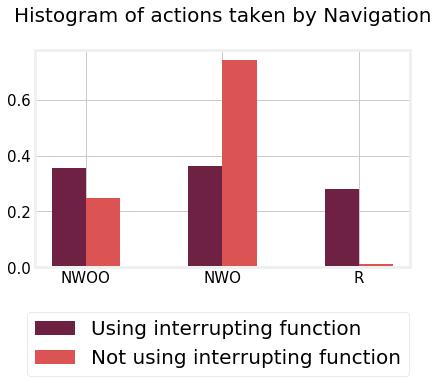

In [191]:
control_actions_count = control_actions.loc[:,control_actions.columns[1:]].groupby(by=int, axis='columns').sum().iloc[-1].values
interrupting_actions_count = interrupting_actions.loc[:,interrupting_actions.columns[1:]].groupby(by=int, axis='columns').sum().iloc[-1].values

control_actions_count /= control_actions_count.sum()
interrupting_actions_count /= interrupting_actions_count.sum()

plt.bar(np.array([1,2,3])-0.25/2,interrupting_actions_count,width=0.25, label="Using interrupting function",color="#6e2142")
plt.bar(np.array([1,2,3])+0.25/2,control_actions_count,width=0.25, label="Not using interrupting function",color="#dc5353")
plt.title("Histogram of actions taken by Navigation\n",fontsize=20)
plt.legend(fontsize=20,loc=[-.02,-.5])
plt.xticks([1,2,3],["NWOO","NWO","R"])
plt.savefig("plots/actions_interruption.pdf",bbox_inches="tight", pad_inches=0)

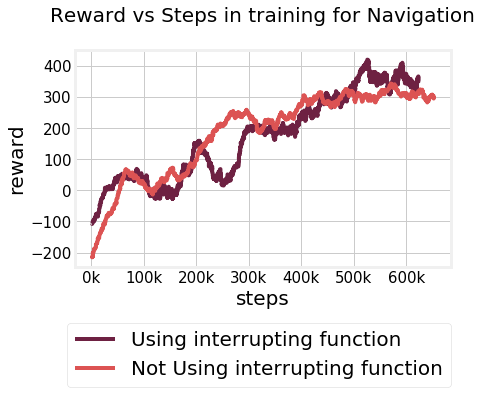

In [190]:
plt.plot(interrupting[1],interrupting[2],color="#6e2142",label="Using interrupting function")
plt.plot(control[1],control[2],color="#dc5353",label="Not Using interrupting function")
plt.legend(fontsize=20,loc=[-.02,-.55])
plt.xticks([i*1e5 for i in range(7)],[str(i*100)+"k" for i in range(7)])
plt.xlabel("steps",fontsize=20)
plt.ylabel("reward",fontsize=20)
plt.title("Reward vs Steps in training for Navigation\n",fontsize=20)
plt.savefig("plots/reward_interruption.pdf",bbox_inches="tight", pad_inches=0)

In [178]:
print("interrupting. hours to reach max",interrupting[0][-1]/3600)
print("control.      hours to reach max",control[0][-1]/3600)

interrupting. hours to reach max 44.23930339568191
control.      hours to reach max 12.583072707321909


# Temporal abstraction

In [203]:
max0 = load_scalars("../experiments/246_Turn_v2_control_max0/logs/PPO2_1/")
max4 = load_scalars("../experiments/245_Turn_v2_control_max4/logs/PPO2_1/")
max20 = load_scalars("../experiments/247_Turn_v2_control_max40/logs/PPO2_1/")
max40 = load_scalars("../experiments/248_Turn_v2_control_max20/logs/PPO2_1/")
max80 = load_scalars("../experiments/249_Turn_v2_control_max80/logs/PPO2_1/")
control = load_scalars("../experiments/250_Turn_v2_n2n_control/logs/PPO2_1/")

max0_disc = load_scalars("../experiments/246_Turn_v2_control_max0/logs/PPO2_1/","input_info/discounted_rewards")
max4_disc = load_scalars("../experiments/245_Turn_v2_control_max4/logs/PPO2_1/","input_info/discounted_rewards")
max20_disc = load_scalars("../experiments/247_Turn_v2_control_max40/logs/PPO2_1/","input_info/discounted_rewards")
max40_disc = load_scalars("../experiments/248_Turn_v2_control_max20/logs/PPO2_1/","input_info/discounted_rewards")
max80_disc = load_scalars("../experiments/249_Turn_v2_control_max80/logs/PPO2_1/","input_info/discounted_rewards")
control_disc = load_scalars("../experiments/250_Turn_v2_n2n_control/logs/PPO2_1/","input_info/discounted_rewards")

Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwri

In [288]:
max0_avg,max0_std,max0_idx,max0_df = avg_std_balanced(vals=max0,group=5000)
max4_avg,max4_std,max4_idx,max4_df = avg_std_balanced(vals=max4,group=5000)
max20_avg,max20_std,max20_idx,max20_df = avg_std_balanced(vals=max20,group=5000)
max40_avg,max40_std,max40_idx,max40_df = avg_std_balanced(vals=max40,group=5000)
max80_avg,max80_std,max80_idx,max80_df = avg_std_balanced(vals=max80,group=5000)

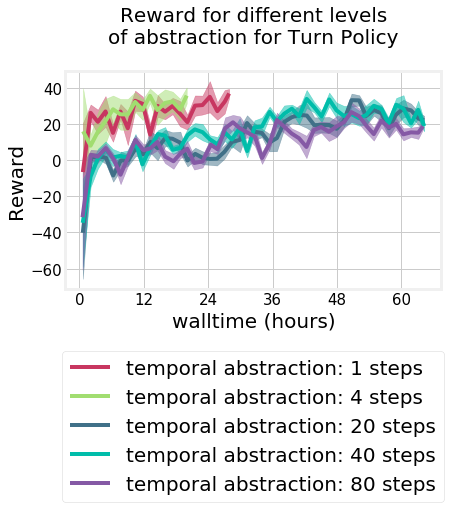

In [289]:
plt.plot(max0_idx,max0_avg,color='#c83660',label="temporal abstraction: 1 steps")
plt.fill_between(max0_idx,max0_avg-max0_std,max0_avg+max0_std,alpha=.5,color='#c83660')

plt.plot(max4_idx,max4_avg,color='#a1dd70',label="temporal abstraction: 4 steps")
plt.fill_between(max4_idx,max4_avg-max4_std,max4_avg+max4_std,alpha=.5,color='#a1dd70')

plt.plot(max20_idx,max20_avg,color='#407088',label="temporal abstraction: 20 steps")
plt.fill_between(max20_idx,max20_avg-max20_std,max20_avg+max20_std,alpha=.5,color='#407088')

plt.plot(max40_idx,max40_avg,color='#00bdaa',label="temporal abstraction: 40 steps")
plt.fill_between(max40_idx,max40_avg-max40_std,max40_avg+max40_std,alpha=.5,color='#00bdaa')

plt.plot(max80_idx,max80_avg,color='#8559a5',label="temporal abstraction: 80 steps")
plt.fill_between(max80_idx,max80_avg-max80_std,max80_avg+max80_std,alpha=.5,color='#8559a5')


plt.ylabel("Reward",fontsize=20)
plt.xlabel("walltime (hours)",fontsize=20)
plt.legend(fontsize=20,loc=[-0.01,-0.98])
plt.xticks([i*12*3600 for i in range(6)],[i*12 for i in range(6)])
plt.title("Reward for different levels\nof abstraction for Turn Policy\n",fontsize=20)
plt.savefig("plots/temporal_abstractions_reward.pdf",bbox_inches="tight", pad_inches=0)

In [283]:
max0_avg,max0_std,max0_idx,max0_df = avg_std_balanced(vals=max0_disc,group=5000)
max4_avg,max4_std,max4_idx,max4_df = avg_std_balanced(vals=max4_disc,group=5000)
max20_avg,max20_std,max20_idx,max20_df = avg_std_balanced(vals=max20_disc,group=5000)
max40_avg,max40_std,max40_idx,max40_df = avg_std_balanced(vals=max40_disc,group=5000)
max80_avg,max80_std,max80_idx,max80_df = avg_std_balanced(vals=max80_disc,group=5000)

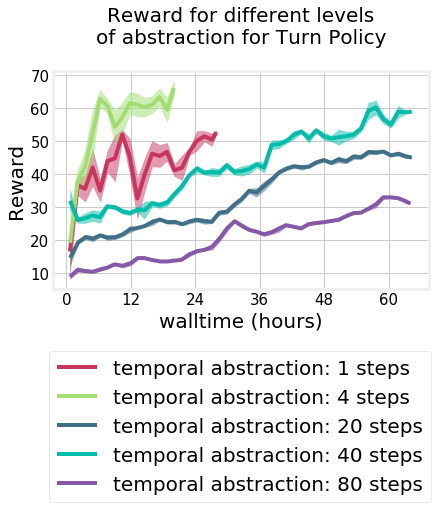

In [285]:
plt.plot(max0_idx,max0_avg,color='#c83660',label="temporal abstraction: 1 steps")
plt.fill_between(max0_idx,max0_avg-max0_std,max0_avg+max0_std,alpha=.5,color='#c83660')

plt.plot(max4_idx,max4_avg,color='#a1dd70',label="temporal abstraction: 4 steps")
plt.fill_between(max4_idx,max4_avg-max4_std,max4_avg+max4_std,alpha=.5,color='#a1dd70')

plt.plot(max20_idx,max20_avg,color='#407088',label="temporal abstraction: 20 steps")
plt.fill_between(max20_idx,max20_avg-max20_std,max20_avg+max20_std,alpha=.5,color='#407088')

plt.plot(max40_idx,max40_avg,color='#00bdaa',label="temporal abstraction: 40 steps")
plt.fill_between(max40_idx,max40_avg-max40_std,max40_avg+max40_std,alpha=.5,color='#00bdaa')

plt.plot(max80_idx,max80_avg,color='#8559a5',label="temporal abstraction: 80 steps")
plt.fill_between(max80_idx,max80_avg-max80_std,max80_avg+max80_std,alpha=.5,color='#8559a5')


plt.ylabel("Reward",fontsize=20)
plt.xlabel("walltime (hours)",fontsize=20)
plt.legend(fontsize=20,loc=[-0.01,-0.98])
plt.xticks([i*12*3600 for i in range(6)],[i*12 for i in range(6)])
plt.title("Reward for different levels\nof abstraction for Turn Policy\n",fontsize=20)
plt.savefig("plots/temporal_abstractions_discounted.pdf",bbox_inches="tight", pad_inches=0)